## The Google Shopping Dataset and Pre-Trained Model

Uses Python 3.12 environment locally

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

### The Dataset

Found on Hugging Face under Marqo/marqo-GS-10M. It has four splits: one for training and three for different model evaluations.

Load the training split. Note that the score and position are for ranking, which BLIP-2 can't handle, so they're irrelevant.

In [2]:
train_df = pd.read_csv('D:/marqo-gs-10m/marqo-gs-dataset/marqo_gs_full_10m/query_0_product_id_0.csv')
train_df

,query,product_id,image_local,position,title,pair_id,score_linear,score_reciprocal,no_score,query_id
0,Earmuffs,11950591053179551937,11950591053179551937.webp,2,La Carrie Faux Fur Headband with Stretch Women...,Earmuffs-11950591053179551937,99,50.000000,1,0
1,Earmuffs,13060356563414168615,13060356563414168615.webp,3,Ugg Women's Shearling Earmuffs - Black,Earmuffs-13060356563414168615,98,33.333333,1,0
2,Earmuffs,6741082963333937131,6741082963333937131.webp,5,Prettylittlething Women's Cream Soft Faux Fur ...,Earmuffs-6741082963333937131,96,20.000000,1,0
3,Earmuffs,8848678524883684053,8848678524883684053.webp,8,Prettylittlething Women's Camel Soft Faux Fur ...,Earmuffs-8848678524883684053,93,12.500000,1,0
4,Earmuffs,11334298244441157208,11334298244441157208.webp,12,Michael Michael Kors Women's Embellished Faux-...,Earmuffs-11334298244441157208,89,8.333333,1,0
...,...,...,...,...,...,...,...,...,...,...
3926759,Vanity with drawers,16127769532516537119,16127769532516537119.webp,93,"Vabches Vanity Desk with Mirror and Lights, Va...",Vanity with drawers-16127769532516537119,8,1.075269,1,98235
3926760,Vanity with drawers,16709308152803456556,16709308152803456556.webp,97,Avery 46 inch Hall Chest Bathroom Vanity by Co...,Vanity with drawers-16709308152803456556,4,1.030928,1,98235
3926761,Vanity with drawers,9387991812768583734,9387991812768583734.webp,98,"Vabches Vanity Desk with Mirror and Lights,Mak...",Vanity with drawers-9387991812768583734,3,1.020408,1,98235
3926762,Vanity with drawers,7515326043655983384,7515326043655983384.webp,99,YITAHOME Vanity Desk Set with Large LED Lighte...,Vanity with drawers-7515326043655983384,2,1.010101,1,98235


Amazingly, there don't appear to be any nulls in this dataset.

In [3]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3926764 entries, 0 to 3926763
Data columns (total 10 columns):
 #   Column            Dtype  
---  ------            -----  
 0   query             object 
 1   product_id        uint64 
 2   image_local       object 
 3   position          int64  
 4   title             object 
 5   pair_id           object 
 6   score_linear      int64  
 7   score_reciprocal  float64
 8   no_score          int64  
 9   query_id          int64  
dtypes: float64(1), int64(4), object(4), uint64(1)
memory usage: 299.6+ MB


Queries (product types) vary in the number of products they have in them

In [4]:
train_df['query'].value_counts()

query
Sushi Plates with Integrated Chopstick Rest     71
Winter Baby Boys' Booties                       70
Eco-Friendly Kids Bed Sheets                    70
Medical professionals walking shoes             70
Assorted boys crew socks                        70
                                                ..
Embossed leather belts                           5
Designer ladles                                  4
solar film installation professional near me     3
Studded belts                                    3
Chimney Cap Installation Service Near Me         2
Name: count, Length: 78588, dtype: int64

Text(0.5, 0, 'Counts')

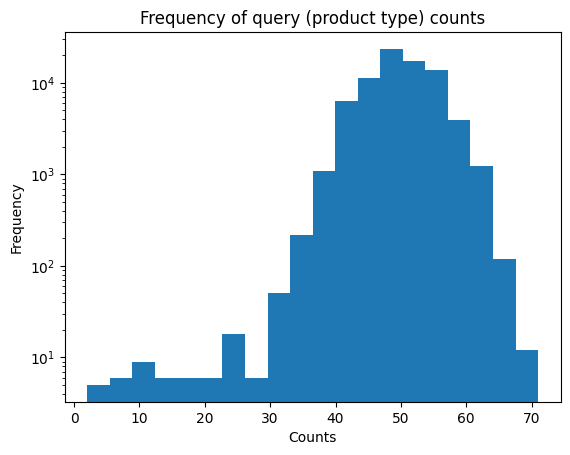

In [5]:
train_df['query'].value_counts().plot.hist(bins=20)
plt.yscale('log')
plt.title('Frequency of query (product type) counts')
plt.xlabel('Counts')

Some products appear many times (in different queries)

In [6]:
train_df['product_id'].value_counts()

product_id
1514677537472852483     141
14657856946271373096    120
12516386939393069095    111
2532920657511662529     106
12288746468413498639    101
                       ... 
10320631035151816845      1
7842326112902460816       1
5799556772308832255       1
7607116747541001666       1
9387991812768583734       1
Name: count, Length: 2332003, dtype: int64

Text(0.5, 0, 'Counts')

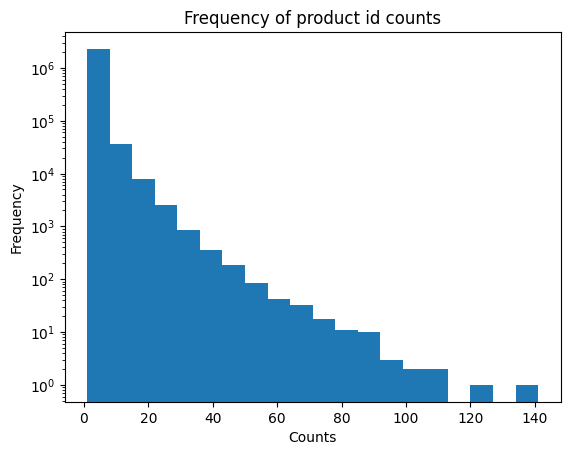

In [7]:
train_df['product_id'].value_counts().plot.hist(bins=20)
plt.yscale('log')
plt.title('Frequency of product id counts')
plt.xlabel('Counts')

Conclusion: We need to take care of both the query and product id frequency. Luckily, PyTorch makes fixing the problem easy by providing the WeightedRandomSampler.

### Brief Examination of the Split for Validation

The queries and documents are both unseen in training.

In [8]:
val_df = pd.read_csv('D:/marqo-gs-10m/marqo-gs-dataset/marqo_gs_full_10m/query_1_product_id_1.csv')
val_df

,query,product_id,image_local,position,title,pair_id,score_linear,score_reciprocal,no_score,query_id
0,Women's earwarmers,6027616271081721900,6027616271081721900.webp,1,La Carrie Faux Fur Headband with Stretch Women...,Women's earwarmers-6027616271081721900,100,100.000000,1,3
1,Women's earwarmers,10596046792613782075,10596046792613782075.webp,4,Earbags 559515 Thinslte Fleece,Women's earwarmers-10596046792613782075,97,25.000000,1,3
2,Women's earwarmers,10842424616201018018,10842424616201018018.webp,5,Earbags Thinslte Fleece Brown - M,Women's earwarmers-10842424616201018018,96,20.000000,1,3
3,Women's earwarmers,3228716393229776255,3228716393229776255.webp,6,Foeses Unisex Warm Knit Earmuffs Ladies Cashme...,Women's earwarmers-3228716393229776255,95,16.666667,1,3
4,Women's earwarmers,6825713981166174988,6825713981166174988.webp,7,Mixit Womens Ear Muffs | White | One Size | Wi...,Women's earwarmers-6825713981166174988,94,14.285714,1,3
...,...,...,...,...,...,...,...,...,...,...
981199,Sports Track Jackets for Training,7419613692543369597,7419613692543369597.webp,92,Locachy Women's Slim Fit Full Zip Athletic Run...,Sports Track Jackets for Training-741961369254...,9,1.086957,1,98231
981200,Sports Track Jackets for Training,11000428475663557098,11000428475663557098.webp,94,Adidas ESI Essentials Warm-Up 3 Stripes Track ...,Sports Track Jackets for Training-110004284756...,7,1.063830,1,98231
981201,Sports Track Jackets for Training,17626895105161115300,17626895105161115300.webp,95,Women's Active Solid Track Jacket,Sports Track Jackets for Training-176268951051...,6,1.052632,1,98231
981202,Sports Track Jackets for Training,7662698481088391635,7662698481088391635.webp,97,Adidas Men's Originals Minoh Half Zip Pullover...,Sports Track Jackets for Training-766269848108...,4,1.030928,1,98231


No null values

In [9]:
val_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 981204 entries, 0 to 981203
Data columns (total 10 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   query             981204 non-null  object 
 1   product_id        981204 non-null  uint64 
 2   image_local       981204 non-null  object 
 3   position          981204 non-null  int64  
 4   title             981204 non-null  object 
 5   pair_id           981204 non-null  object 
 6   score_linear      981204 non-null  int64  
 7   score_reciprocal  981204 non-null  float64
 8   no_score          981204 non-null  int64  
 9   query_id          981204 non-null  int64  
dtypes: float64(1), int64(4), object(4), uint64(1)
memory usage: 74.9+ MB


### Pre-Trained Model

The group does provide a pre-trained model. However, it is truly a CLIP model. I don't see any way to get a unified multimodal embedding out of it. It has an encode_image and encode_text method, but no way to do both at the same time.

In [34]:
import open_clip

model, _, preprocess = open_clip.create_model_and_transforms('ViT-L-14', pretrained='D:/marqo-gs-10m/marqo-gcl-vitl14-124-gs-full_states.pt')
tokenizer = open_clip.get_tokenizer('ViT-L-14')

In [35]:
model

CLIP(
  (visual): VisionTransformer(
    (conv1): Conv2d(3, 1024, kernel_size=(14, 14), stride=(14, 14), bias=False)
    (patch_dropout): Identity()
    (ln_pre): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
    (transformer): Transformer(
      (resblocks): ModuleList(
        (0-23): 24 x ResidualAttentionBlock(
          (ln_1): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
          (attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=1024, out_features=1024, bias=True)
          )
          (ls_1): Identity()
          (ln_2): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
          (mlp): Sequential(
            (c_fc): Linear(in_features=1024, out_features=4096, bias=True)
            (gelu): GELU(approximate='none')
            (c_proj): Linear(in_features=4096, out_features=1024, bias=True)
          )
          (ls_2): Identity()
        )
      )
    )
    (ln_post): LayerNorm((1024,), eps=1e-05, elementwi